In this notebook we will experiment with the keras backend to build the components for a deep dream implementation.  We follow the keras github page [here](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) pretty closely.

In [33]:
import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras.applications import vgg16
from keras import backend as K

import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display

# build the VGG16 network with ImageNet weights
vgg = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')
vgg.summary()


Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0      

(1, 200, 200, 3)


/home/joe/tensorflow-1.13_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


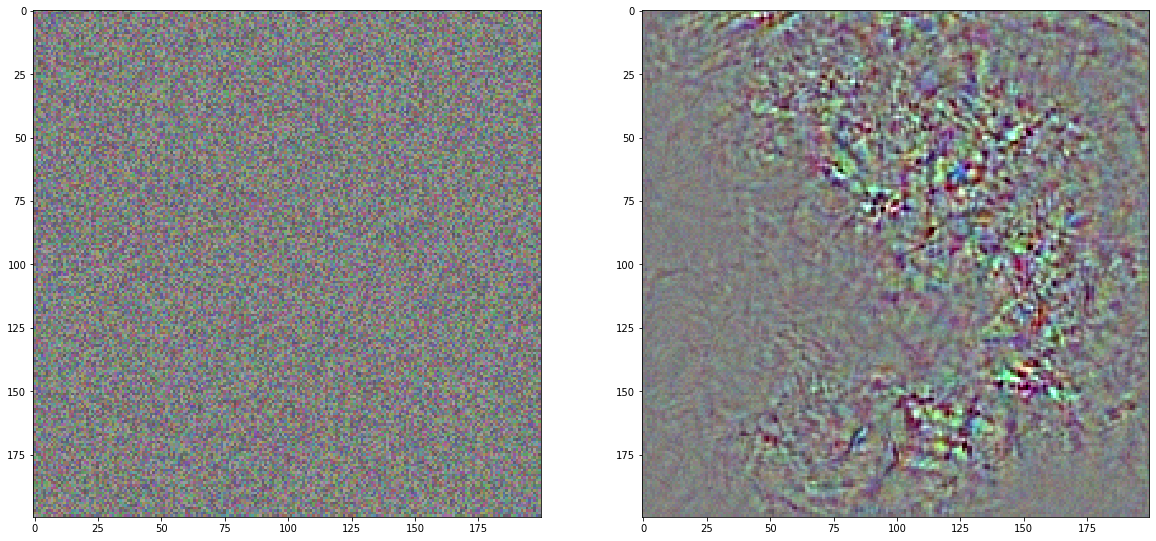

In [70]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8', casting='unsafe')
    return x

def step(model, output_layer, filter_index, img):
    # calculate L_1 loss
    loss = K.mean(output_layer.output[:, :, :, filter_index])

    # make gradients
    grads = K.gradients(loss, model.inputs[0])[0]
    grads =  grads / (K.sqrt(K.mean(K.square(grads))) + K.epsilon())

    step = K.function([model.inputs[0]], [loss, grads])

    return step([img])
    
def get_layer_by_name(model, layer_name):
    # use model.summary to see the layer names.
    layer_dict = dict([(layer.name, layer) for layer in vgg.layers[1:]])

    if layer_name in layer_dict:
        return layer_dict[layer_name]
    else: return None

def get_random_filter(model, layer):
    # get a filter from model
    filter_upper = len(layer.get_weights()[1])

    assert(filter_upper > 0)

    # pick a random filter index
    return np.random.randint(filter_upper)

    
#test
output_layer = get_layer_by_name(vgg, 'block5_conv3')
assert isinstance(output_layer, layers.Conv2D)

idx = get_random_filter(vgg, output_layer)

## create an image for the input.
input_img_data = np.random.random((1, 200, 200, 3))

# output loss from one step
loss, gradients = step(vgg, output_layer, idx, input_img_data)
print(gradients.shape)

next_image = input_img_data + gradients

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 10))


ax1.imshow(deprocess_image(input_img_data.reshape(200,200,3)))
#ax1.set_title('original')
ax2.imshow(deprocess_image(next_image.reshape(200,200,3)))
#ax2.set_title('one step gradient')
fig.show()


/home/joe/tensorflow-1.13_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


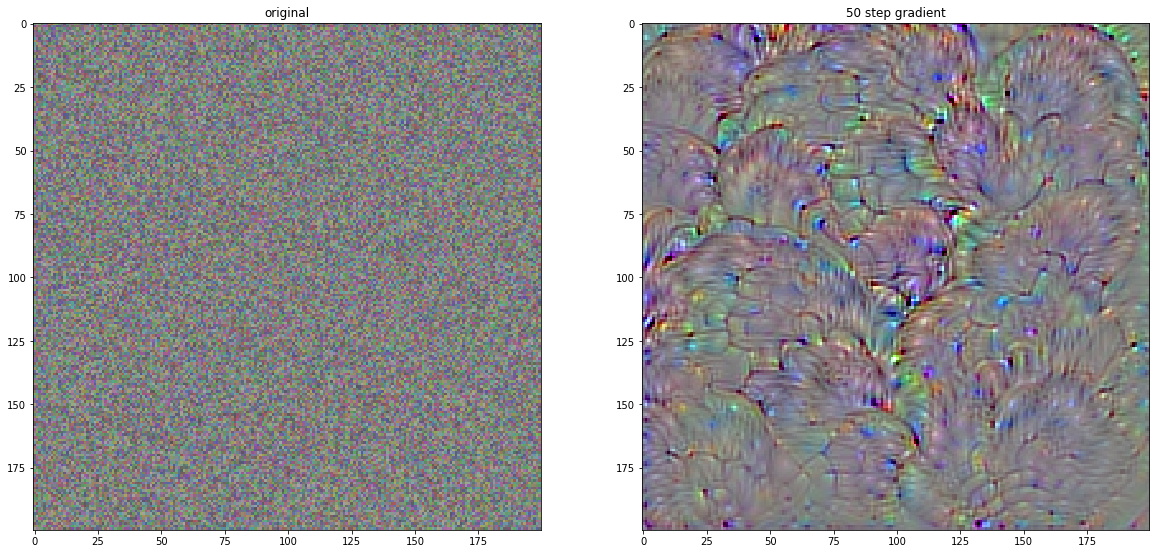

In [71]:
# now create a function to iterate the gradients to add to the image.
def iterate_grads(model, layer_name, filter_index, iterations, img):
    next_image = img
    for _ in range(iterations):
        loss, gradients = step(model, layer_name, filter_index, next_image)
        next_image = next_image + gradients
    return next_image

iter = 50
final_img = iterate_grads(vgg,  output_layer, idx, iter, input_img_data)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 10))

ax1.imshow(deprocess_image(input_img_data.reshape(200,200,3)))
ax1.set_title('original')
ax2.imshow(deprocess_image(final_img.reshape(200,200,3)))
ax2.set_title('{} step gradient'.format(iter))
fig.show()

/home/joe/tensorflow-1.13_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


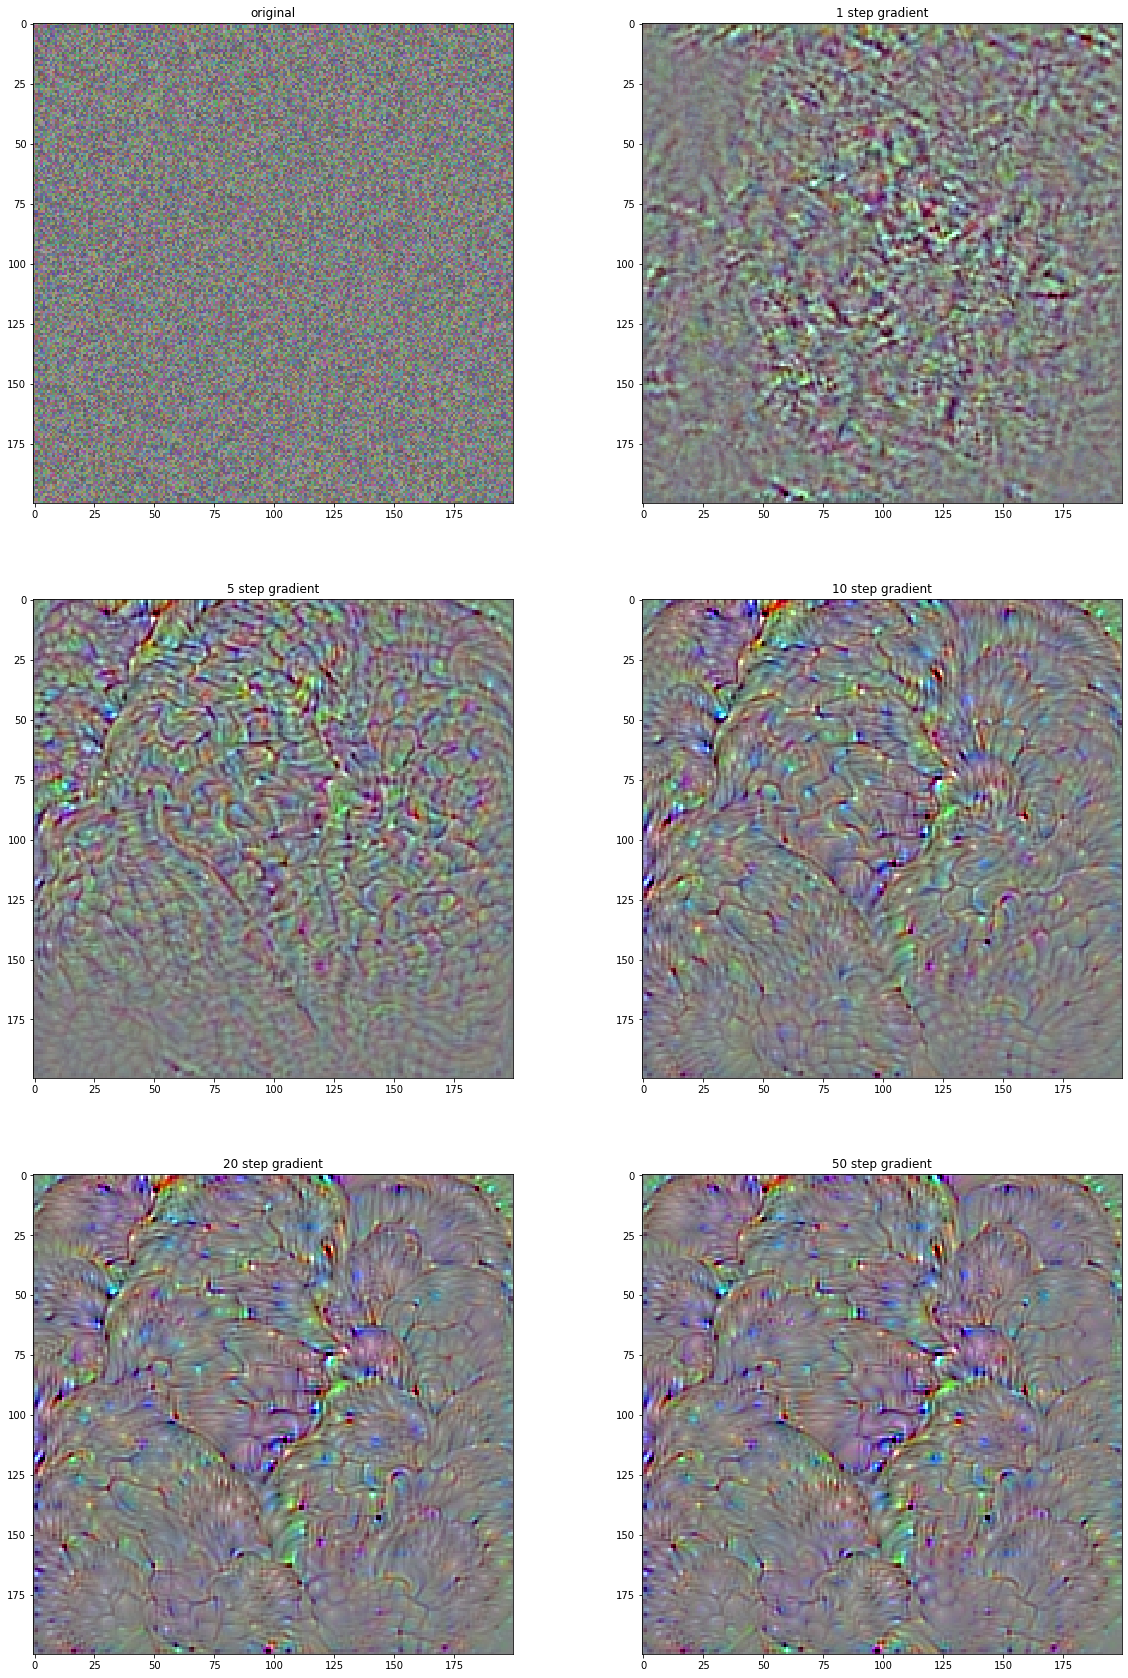

In [72]:
# how does the gradient change over the number of iterations?
iters = [1, 5, 10, 20, 50]

image1 = iterate_grads(vgg,  output_layer, idx, iters[0], input_img_data)
image2 = iterate_grads(vgg,  output_layer, idx, iters[1], image1)
image3 = iterate_grads(vgg,  output_layer, idx, iters[2], image2)
image4 = iterate_grads(vgg,  output_layer, idx, iters[3], image3)
image5 = iterate_grads(vgg,  output_layer, idx, iters[4], image4)

# draw
fig, ax = plt.subplots(3,2,figsize=(20, 30))

ax[0,0].imshow(deprocess_image(input_img_data.reshape(200,200,3)))
ax[0,0].set_title('original')
ax[0,1].imshow(deprocess_image(image1.reshape(200,200,3)))
ax[0,1].set_title('{} step gradient'.format(iters[0]))
ax[1,0].imshow(deprocess_image(image2.reshape(200,200,3)))
ax[1,0].set_title('{} step gradient'.format(iters[1]))
ax[1,1].imshow(deprocess_image(image3.reshape(200,200,3)))
ax[1,1].set_title('{} step gradient'.format(iters[2]))
ax[2,0].imshow(deprocess_image(image4.reshape(200,200,3)))
ax[2,0].set_title('{} step gradient'.format(iters[3]))
ax[2,1].imshow(deprocess_image(image5.reshape(200,200,3)))
ax[2,1].set_title('{} step gradient'.format(iters[4]))
fig.show()

(2048, 1152, 3)
<class 'imageio.core.util.Array'>
(1, 2048, 1152, 3)


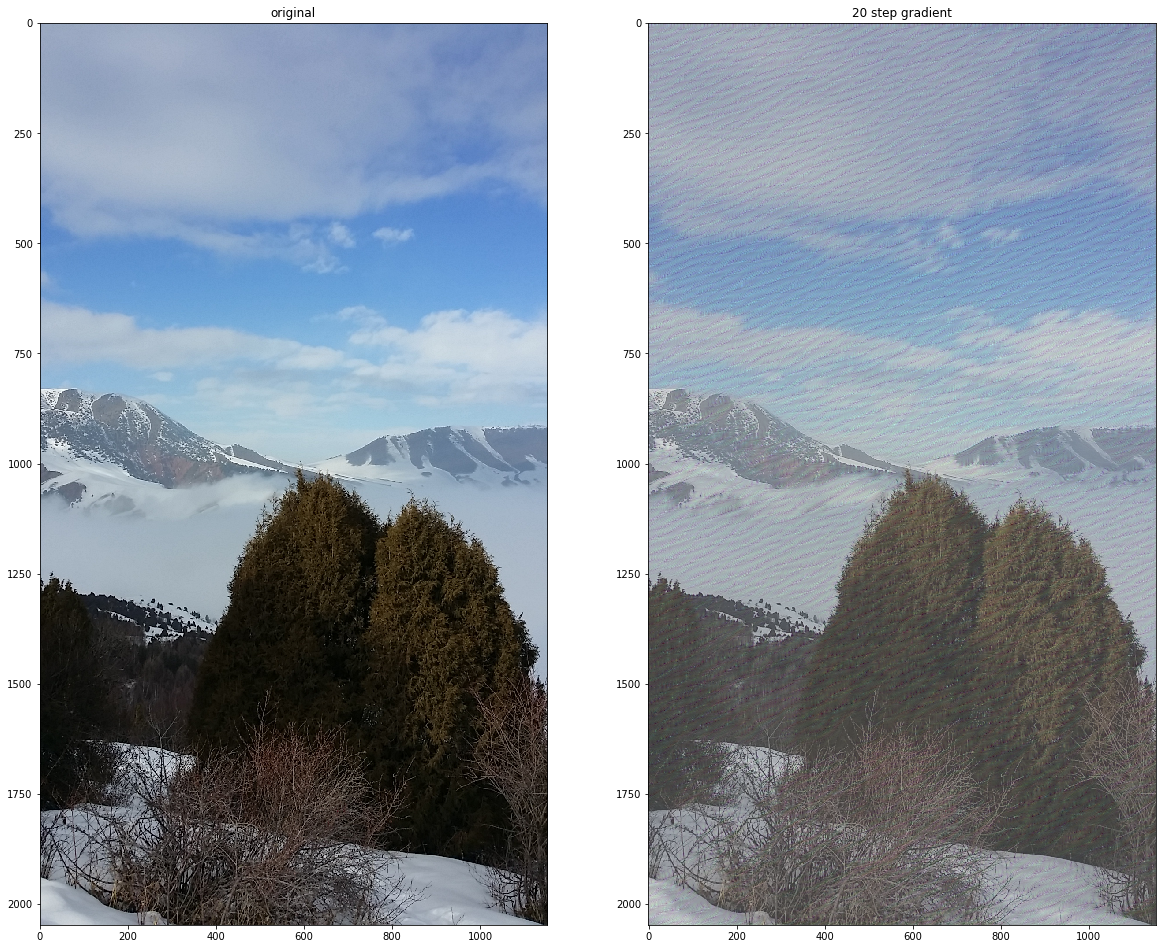

In [97]:
# What about with a picture instead of a random input?
from imageio import imread

def minmax_deprocess(image):
    maximum = float(image.max())
    minimum = float(image.min())
    
    # clip [0,1]
    scaled = (image - minimum)/float(maximum-minimum)
    
    # rescale to [0,255]
    new_image = scaled * 255
    return new_image.astype('uint8')

#img = imread('imageio:chelsea.png')
img = imread('../test_images/mountains1.jpg')
img_shape = img.shape
print(img.shape)
print(type(img))

# make image tensor rank 4
img = np.reshape(img ,(1, img_shape[0], img_shape[1], img_shape[2])).astype('float32')

its = 20
image1 = iterate_grads(vgg,  get_layer_by_name(vgg,'block4_conv1'), 19, its, img)
print(image1.shape)


fig, ax = plt.subplots(1,2,figsize=(20, 40))

ax[0].imshow(minmax_deprocess(img.reshape(img_shape[0], img_shape[1], img_shape[2])))
#ax[0].imshow(img.reshape(img_shape[0], img_shape[1], img_shape[2]))
ax[0].set_title('original')
ax[1].imshow(minmax_deprocess(image1.reshape(img_shape[0], img_shape[1], img_shape[2])))
#ax[1].imshow(image1.reshape(img_shape[0], img_shape[1], img_shape[2]))
ax[1].set_title('{} step gradient'.format(its))

plt.show()


In [ ]:
# Finally, print images for each filter and name by filter index.
